In [1]:
from main import init_detectron
import os
from tqdm.notebook import tqdm
from random import sample
import cv2
import numpy as np
from itertools import compress
import torchvision
from torch.utils.data import DataLoader, random_split
from stacker_net.train import MyDataset
from stacker_net.net import StackerNet
from torch import nn
import torch
import json
import pickle
from outpainter_net.net import OutpainterNet
from outpainter_net.train import construct_dataset, train
from PIL import Image

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
data = []
for root, dirs, files in os.walk('data/data_256'):
    if files:
        data.append((root, files))

In [3]:
predictor, coi = init_detectron()

In [4]:
selection_filename = 'data/selected_images.json'
force_overwrite = False

if not os.path.isfile(selection_filename) or force_overwrite:
    global ratios, data2, paths
    ratios = []
    for category in tqdm(data):
        samples = sample(category[1], 25)
        total = len(samples)
        positives = 0
        for img_name in samples:
            img = cv2.imread(os.path.join(category[0], img_name))
            outputs = predictor(img)
            if coi.intersection(outputs['instances'].pred_classes.cpu().numpy()):
                positives += 1
        ratios.append(positives / total)
    data2 = list(compress(data, np.array(ratios) >= 0.96))
    paths = [os.path.join(category[0], file) for category in data2 for file in category[1]]
    with open(selection_filename, 'w') as f:
        json.dump(paths, f)
else:
    with open(selection_filename, 'r') as f:
        paths = json.load(f)

In [5]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.ConvertImageDtype(torch.float32)
])
img_ds = MyDataset('data/data_256', paths, transform=transforms)

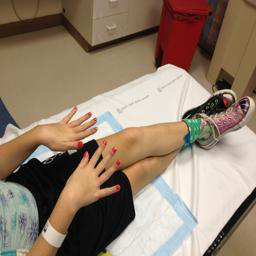

In [6]:
import random
samples = random.sample(range(len(img_ds)), 3)
transform = torchvision.transforms.ToPILImage()
display(transform(img_ds[samples[0]]))

In [7]:
fname = "data/chunk4_dataset.pkl"
force_overwrite = False

if force_overwrite or not os.path.isfile(fname):
    ds = construct_dataset(img_ds, sample_size=100000)
    with open(fname, "wb") as f:
        pickle.dump(ds, f)
else:
    with open(fname, "rb") as f:
        ds = pickle.load(f)

: 

: 

In [ ]:
BATCH_SIZE = 128

train_len = int(len(ds) * 0.8)
val_len = len(ds) - train_len
train_ds, val_ds = random_split(ds, (train_len, val_len))
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, BATCH_SIZE, pin_memory=True)

In [ ]:
len(ds)

6300000

In [7]:
model = OutpainterNet().to(device)

In [8]:
model.load_state_dict(torch.load("outpainter_net/state.pt"))
model.eval()

OutpainterNet(
  (net): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): ReLU()
    (8): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(1, 1))
    (9): Sigmoid()
  )
)

In [10]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
train(model, loss_fn, optimizer, train_dl, val_dl, device=device, print_metrics=True, epochs=50)
torch.save(model.state_dict(), "outpainter_net/state.pt")

 10%|█         | 1/10 [03:35<32:18, 215.40s/it]

Epoch 0: train loss = 0.012, val loss = 0.011


 20%|██        | 2/10 [06:00<23:11, 173.99s/it]

Epoch 1: train loss = 0.011, val loss = 0.011


 30%|███       | 3/10 [07:38<16:13, 139.12s/it]

Epoch 2: train loss = 0.011, val loss = 0.011


 40%|████      | 4/10 [09:15<12:15, 122.53s/it]

Epoch 3: train loss = 0.011, val loss = 0.011


 50%|█████     | 5/10 [10:52<09:27, 113.42s/it]

Epoch 4: train loss = 0.011, val loss = 0.011


 60%|██████    | 6/10 [12:29<07:11, 107.91s/it]

Epoch 5: train loss = 0.011, val loss = 0.011


 70%|███████   | 7/10 [14:06<05:12, 104.32s/it]

Epoch 6: train loss = 0.011, val loss = 0.010


 80%|████████  | 8/10 [15:44<03:24, 102.21s/it]

Epoch 7: train loss = 0.010, val loss = 0.010


 90%|█████████ | 9/10 [17:22<01:41, 101.11s/it]

Epoch 8: train loss = 0.010, val loss = 0.010


100%|██████████| 10/10 [19:02<00:00, 114.21s/it]

Epoch 9: train loss = 0.010, val loss = 0.010


In [13]:
img = img_ds[30]
transform = torchvision.transforms.ToPILImage()
timg = transform(img)

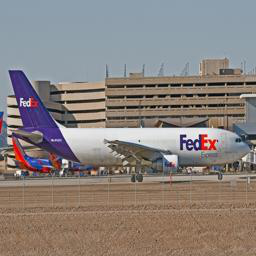

In [14]:
display(timg)

In [15]:
img.shape

torch.Size([3, 256, 256])

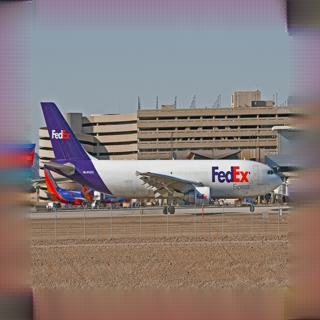

In [16]:
pred = model.image_outpaint(img.to(device).unsqueeze(0), (320, 320)).squeeze()
new_img = pred
timg = transform(img)
display(transform(new_img))

In [21]:
img = Image.fromarray(cv2.imread("data/6001481133_06841baef7_c.jpg")[..., ::-1])

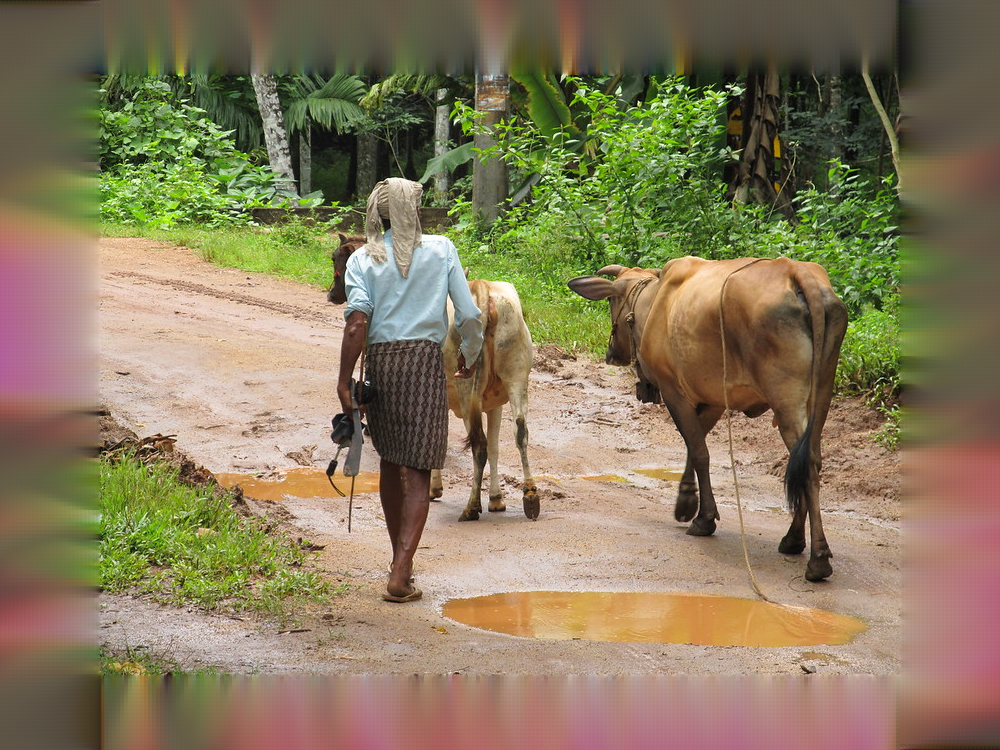

In [24]:
pred = model.image_outpaint(transforms(img).to(device).unsqueeze(0), (1000, 750)).squeeze()
display(transform(pred))